# Simple Features exploration

We design some simple features (important in a limited quantity) and explore modeling on all combinations of features.

## Global Process

1. Add features to the input data
2. Generate some weights so distribution of is_duplicate in training matches the one in challenge data
3. Do some basic exploration of each unique feature. Is there any chance it can help to separate is_duplicate
4. Pick an algorithm
5. Explore all combination of features. 8 features generate 255 combinations
6. For each combination
    * 2 models are generated : 80,20 and 100,0 partitions
    * for each model, we keep
        ** logloss : the main metric choosen for the challenge
        ** accuracy
        ** score ie f1-score
        ** the combination of features
        ** the model
6. This 'database' of results is saved (excel and pickle)
7. Using this 'database' of results, we do some graphs
8. We choose the best models for a given metric and apply them to challenge data
9. Scorings are submitted to Kaggle
10. Evaluations from kaggle are downloaded and graphed

## Training of models
Code is available for 3 'strategies' to built each model
### All default parameters
Obviously, the fastest
### All default parameters with cross validation
Only one model is built. There is no 80,20/100,0 as all is driven by cross validation
For each iteration, we store more informations
    * for each metric: min,max,mean,std, best fold
    * model
The best fold for a given gives the best model. Currently, there is no dramatic difference between min,max and mean of each metric
Still, Kaggle score is little bit better
### Exploration of Hyper parameters 

A search for best parameters is done via:
    * RandomizedSearchCV
    * GridSearchCV

Currently and strangely, strategy with hyper parameters is under Simple Cross Validatin but this may change with algorithms and new features






In [1]:
# Ugly incantation to make our 'framework' working
import sys
sys.path.insert(0, r'/SAPDevelop/QuoraPairs/BruteForce/Tools')

#import all our small tools (paths, cache, print,zip,excel, pandas, progress,..)
from Tools.all import *

# setup the name of our experiment
# it will be used to store every result in a unique place
EXPERIMENT='more_features_exploration'
# Do a bit of checks before actually running code
UNITARY_TEST = True
print_alert('You will use environment %s' % EXPERIMENT)

## Build our simple features
* Nb words in question 1
* Nb words in question 2
* abs(Nb words in question 1 - Nb words in question 2)
* Nb common words
* Nb common words/nb words in question 1
* Nb common words/nb words in question 2
* Nb non common words in question 1
* Nb non common words in question 2
* Nb common words/(Nb words in question1 + Nb words in question2)

**Notes**
* Input data is not processed except for basic unicode clean
* Heavy to generate so result is cached
* This may be overkill as features will be eliminated but features are also generated for challenge data

In [9]:
def add_column_from_columns(dataframe,output_column_name,function):
    dataframe[output_column_name]=dataframe.progress_apply(function,axis=1)
    return dataframe[output_column_name]

def add_column_from_column(dataframe,output_column_name,input_column_name,function):
    dataframe[output_column_name]=dataframe[input_column_name].progress_apply(function)
    return dataframe[output_column_name]

def build_all_simple_features(dataframe):
    print_warning('Compute common_words between question1 & question2')
    add_column_from_column(dataframe,'nb_words_question1','question1',lambda x: len(x.split()))
    add_column_from_column(dataframe,'nb_words_question2','question2',lambda x: len(x.split()))

    print_warning('Compute abs(Nb words in question 1 - Nb words in question 2)')
    add_column_from_columns(dataframe,'abs(nb1-nb2)',lambda r: abs(r.nb_words_question1-r.nb_words_question2))

    print_warning('Compute Nb common_words between question1 & question2')
    add_column_from_columns(dataframe,'common_words',lambda r: list(set(r.question1.split())&set(r.question2.split())))
    add_column_from_column(dataframe,'nb_common_words','common_words',len)

    print_warning('Compute Nb common words/nb words in question1')
    add_column_from_columns(dataframe,'nb_common_words/nb_words_question1',lambda r: r.nb_common_words/max(1,r.nb_words_question1))
    print_warning('Compute Nb common words/nb words in question2')
    add_column_from_columns(dataframe,'nb_common_words/nb_words_question2',lambda r: r.nb_common_words/max(1,r.nb_words_question2))

    print_warning('Compute Nb words in question1,question2 not in common words')
    add_column_from_columns(dataframe,'nb_words_question1-common_words',lambda r: len(list(set(r.question1.split())-set(r.common_words))))
    add_column_from_columns(dataframe,'nb_words_question2-common_words',lambda r: len(list(set(r.question2.split())-set(r.common_words))))
    print_warning('Compute (nb common words)/(nb words in question1+nb word in question2)')
    add_column_from_columns(dataframe,'nb_common_words/(nb_words_question1+nb_words_question2)',lambda r: r.nb_common_words/(r.nb_words_question1+r.nb_words_question2))
    dataframe=dataframe.drop(columns='common_words')
    return dataframe

In [10]:
prepare_environnement(EXPERIMENT)
train_dataframe=load_dataframe(CLEAN_TRAINING_DATA)
challenge_dataframe=load_dataframe(CLEAN_CHALLENGE_DATA)
print_section('Untouched input data has been loaded. Training: %d lines Challenge: %d lines' % (len(train_dataframe),len(challenge_dataframe)))

train_dataframe=load_or_build_dataframe('Training data + basic features','training_basic_features',build_all_simple_features,train_dataframe)
challenge_dataframe=load_or_build_dataframe('Challenge data + basic features','challenge_basic_features',build_all_simple_features,challenge_dataframe)

## Challenge and training are not equivalent

% of duplicate in training is not the same in challenge !
We don't have the challenge's answer but by scoring a constant prediction and using logloss definition, we can guess the distribution of duplicates in challenge

It's 17.46 %

To fix that we can:

* duplicate some negative cases in training to match challenge distribution
* use weights : each case has a weight !=1 and all algorithms are supposed to be able to deal with that info
I choose to use weights (less memory needed ?)

In [11]:
# return the weight for 0 and weight for 1 needed to rebalance dataframe like challenge
def balanced_weights(dataframe,expected_positive_ratio):
    current_positive_ratio = dataframe['is_duplicate'].sum()/len(dataframe)
    weight_for_negative = (1-expected_positive_ratio)/(1-current_positive_ratio)
    weight_for_positive = expected_positive_ratio/current_positive_ratio
    return weight_for_positive,weight_for_negative
    return 1,


CHALLENGE_DUPLICATE_PERCENT = 0.1746
print_warning('OUPS !! %% of duplicates in train is %.3f. In challenge it is %.3f %%' % (train_dataframe['is_duplicate'].sum()/len(train_dataframe),CHALLENGE_DUPLICATE_PERCENT))

# create a new 'weight' column to training dataset
# Do not forget to remove this column from features !!!
weight_for_1,weight_for_0 = balanced_weights(train_dataframe,CHALLENGE_DUPLICATE_PERCENT)
print_info('Weight for positive case %.3f' % weight_for_1)
print_info('Weight for negative case %.3f' % weight_for_0)
train_dataframe['weight'] = train_dataframe['is_duplicate'].map( {0:weight_for_0, 1:weight_for_1})

assert int(train_dataframe['weight'].sum()/len(train_dataframe)) == 1, "training dataset has not been properly rebalanced"
print_info("Training data set has been properly rebalanced")
print_info('Weights distribution:')
train_dataframe['weight'].describe()

count    404290.000000
mean          1.000000
std           0.403239
min           0.472917
25%           0.472917
50%           1.308493
75%           1.308493
max           1.308493
Name: weight, dtype: float64

## Compute AUC of these basic features and try to figure if there is a bit of information inside each one

ie is it helping to separate 1 from 0?

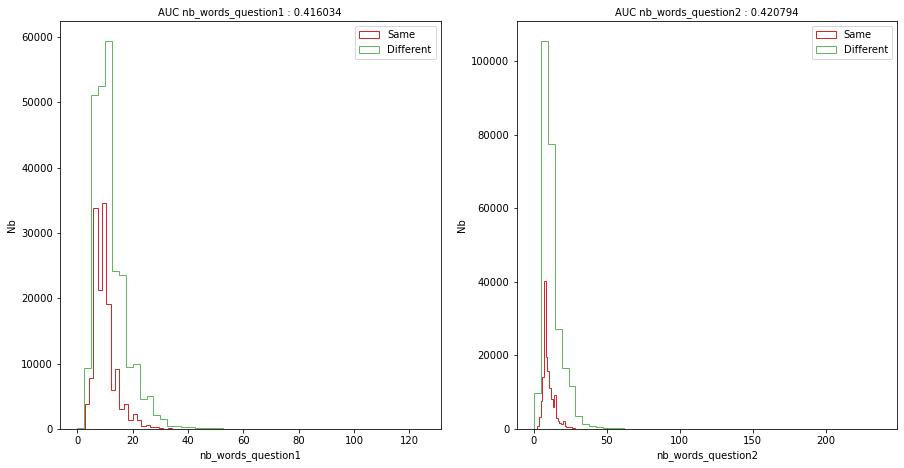

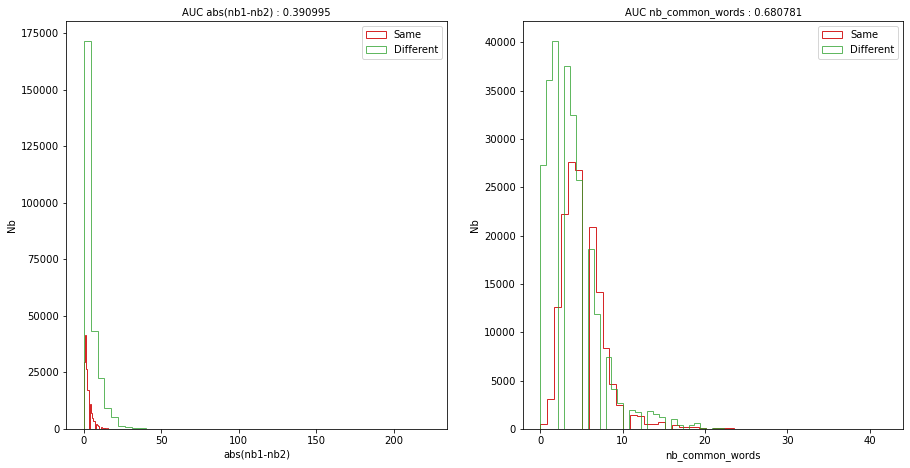

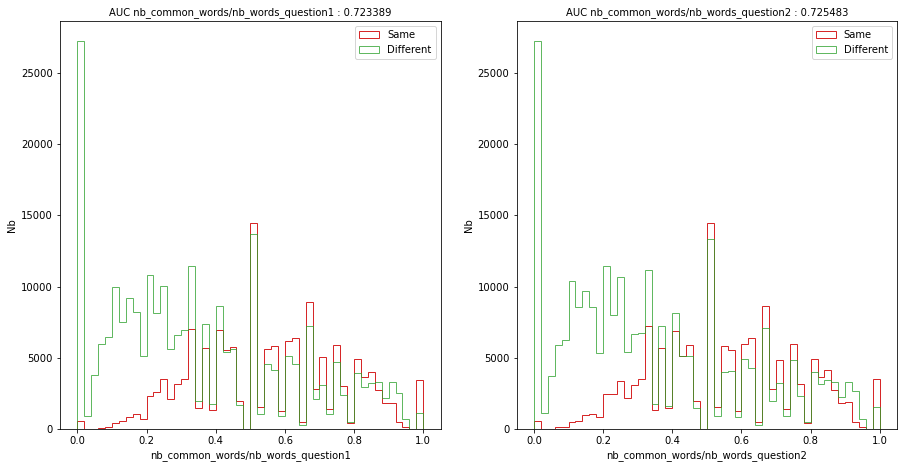

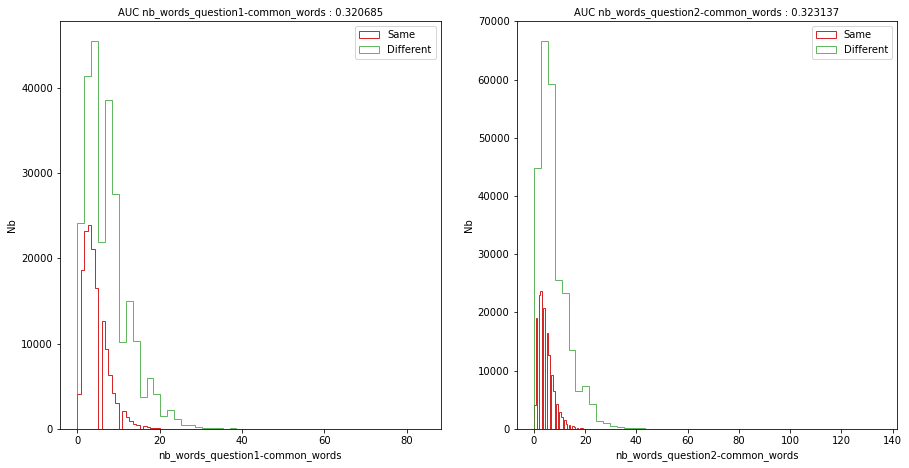

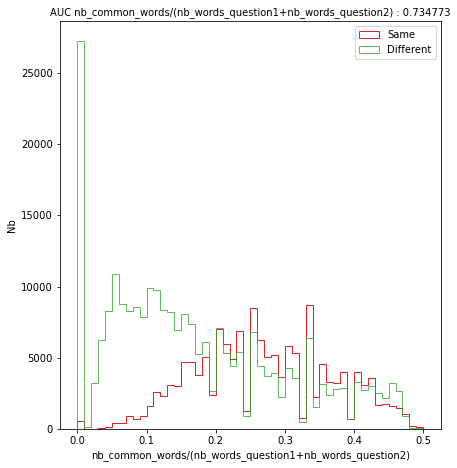

In [12]:
from sklearn.metrics import roc_auc_score

def simple_AUC(dataframe,column_name):
    return roc_auc_score(y_true=dataframe['is_duplicate'],y_score=dataframe[column_name])

def simple_weighted_AUC(dataframe,column_name):
    return roc_auc_score(y_true=dataframe['is_duplicate'],y_score=dataframe[column_name],sample_weight=dataframe['weight'])

def show_AUC(dataframe,column_name):
    print_bullet('AUC %s: %f' % (column_name,simple_AUC(dataframe,column_name)))
    if 'weight' in dataframe.columns:
        print_bullet('Weighted AUC %f' % simple_weighted_AUC(dataframe,column_name))
    else:
        print_bullet('AUC %f' % simple_AUC(dataframe,column_name))
        

def display_simple_AUC(dataframe,column_name):
    palette = sns.color_palette()
    # Let multiplot_generator figure the size
    #plot.figure(figsize=(10, 7))
    plot.hist(dataframe[column_name][dataframe['is_duplicate']==1],bins=50,color=palette[3],label='Same',histtype='step')
    plot.hist(train_dataframe[column_name][dataframe['is_duplicate']==0],bins=50,color=palette[2],label='Different',alpha = 0.75,histtype='step')
    plot.title('AUC %s : %f' % (column_name,simple_AUC(dataframe,column_name)) , fontsize=10)
    plot.xlabel(column_name)
    plot.ylabel('Nb')
    plot.legend()



def show_all_simple_AUC(dataframe):
    all =  all_numeric_columns(dataframe)
    print_section( 'Show AUC on %d unique features' % len(all))
    for name in all:
        show_AUC(dataframe,name)
        yield
        display_simple_AUC(dataframe,name)
    print_done('Done')


def show_all_simple_AUC_in_grid(dataframe,nb_columns=2):
    multiplot_from_generator(show_all_simple_AUC(dataframe), nb_columns)

show_all_simple_AUC_in_grid(train_dataframe,nb_columns=2)

## Here are the specs of algorithms to try

In [13]:
# Here is our algorithm specification
HYPER_PARAMETERS_MULTINOMIAL_NAIVE_BAYES_FIRST_TRY = {
    'alpha':[1e-10,1e-08,1e-06,1e-04,1e-02,1e-01,1.0]
    }

HYPER_PARAMETERS_MULTINOMIAL_NAIVE_BAYES_FINE_TUNING = {
    'alpha':[0.8e-10,0.9e-10,1.0e-10,1.1e-10,1.2e-10]
    }

ALGORITHM_SPEC_MULTINOMIAL_NB_RANDOMIZED_SEARCH = {
    'algorithm': MultinomialNB,
    'searcher': RandomizedSearchCV,
    'hyper_parameters': {
        'alpha':[1e-10,1e-08,1e-06,1e-04,1e-02,1e-01,1.0]
    }
}

ALGORITHM_SPEC_COMPLEMENT_NB = {
    'algorithm': ComplementNB
}

if UNITARY_TEST:
    print_section('Unitary test: one default model (80,20) & (100,0) using feature nb_words_question1')
    res = build_model_80_20_and_100_0(ALGORITHM_SPEC_COMPLEMENT_NB,train_dataframe,['nb_common_words/nb_words_question1', 'nb_words_question1-common_words', 'nb_words_question2-common_words', 'nb_common_words/(nb_words_question1+nb_words_question2)'],train_dataframe['is_duplicate'])
    print(res)

# Unitary test
if UNITARY_TEST:
    print_section('Unitary test : optimize one model (80,20) & (100,0) using feature nb_words_question1')
    res = build_model_80_20_and_100_0_hyper(ALGORITHM_SPEC_MULTINOMIAL_NB_RANDOMIZED_SEARCH,train_dataframe,['nb_common_words/nb_words_question1', 'nb_words_question1-common_words', 'nb_words_question2-common_words', 'nb_common_words/(nb_words_question1+nb_words_question2)'],train_dataframe['is_duplicate'])
    print( res)

if UNITARY_TEST:
    small_train = train_dataframe.sample(100,random_state=42)
    res = build_default_model_on_all_subset_of_simple_features(ALGORITHM_SPEC_MULTINOMIAL_NB_RANDOMIZED_SEARCH,small_train,small_train['is_duplicate'])

if UNITARY_TEST:
    small_train = train_dataframe.sample(100,random_state=42)
    res = build_hyper_model_on_all_subset_of_simple_features(ALGORITHM_SPEC_MULTINOMIAL_NB_RANDOMIZED_SEARCH,small_train,small_train['is_duplicate'])

Classification report on 80_20
              precision    recall  f1-score   support

           0       0.91      0.65      0.76 66475.35427891841
           1       0.30      0.69      0.42 14213.525233116525

    accuracy                           0.66 80688.87951203494
   macro avg       0.60      0.67      0.59 80688.87951203494
weighted avg       0.80      0.66      0.70 80688.87951203494



Classification report on 100_0
              precision    recall  f1-score   support

           0       0.91      0.66      0.76 333700.9660020216
           1       0.30      0.69      0.42 70589.0339997351

    accuracy                           0.66 404290.0000017567
   macro avg       0.60      0.67      0.59 404290.0000017567
weighted avg       0.80      0.66      0.70 404290.0000017567



{'accuracy_80_20': 0.6610309902990631, 'score_80_20': 0.7004636683195876, 'logloss_proba_80_20': 0.6123861201725102, 'model_80_20': ComplementNB(), 'time_80_20': 0.05418682098388672, 'accuracy_100_0': 0.6612999633373224, 'score_100_0': 0.7011559815347109, 'logloss_proba_100_0': 0.6118306951072937, 'model_100_0': ComplementNB(), 'time_100_0': 0.059569597244262695, 'nb_features': 4, 'column_names': 'nb_common_words/nb_words_question1+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2)', 'columns': ['nb_common_words/nb_words_question1', 'nb_words_question1-common_words', 'nb_words_question2-common_words', 'nb_common_words/(nb_words_question1+nb_words_question2)']}


Fitting 5 folds for each of 7 candidates, totalling 35 fits
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=7)]: Done  35 out of  35 | elapsed:    1.8s finished
Classification report on 80_20
              precision    recall  f1-score   support

           0       0.82      1.00      0.90 66475.35427891841
           1       0.00      0.00      0.00 14213.525233116525

    accuracy                           0.82 80688.87951203494
   macro avg       0.41      0.50      0.45 80688.87951203494
weighted avg       0.68      0.82      0.74 80688.87951203494



Fitting 5 folds for each of 7 candidates, totalling 35 fits
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  22 out of  35 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=7)]: Done  35 out of  35 | elapsed:    0.9s finished
Classification report on 100_0
              precision    recall  f1-score   support

           0       0.83      1.00      0.90 333700.9660020216
           1       0.00      0.00      0.00 70589.0339997351

    accuracy                           0.83 404290.0000017567
   macro avg       0.41      0.50      0.45 404290.0000017567
weighted avg       0.68      0.83      0.75 404290.0000017567



{'accuracy_80_20': 0.8238477802763291, 'score_80_20': 0.7442783026145227, 'logloss_proba_80_20': 0.4203864559337953, 'model_80_20': MultinomialNB(alpha=1e-10), 'params_80_20': {'alpha': 1e-10}, 'time_80_20': 2.413559675216675, 'accuracy_100_0': 0.8253999999982544, 'score_100_0': 0.7464502684347297, 'logloss_proba_100_0': 0.4180232432549241, 'model_100_0': MultinomialNB(alpha=1e-10), 'params_100_0': {'alpha': 1e-10}, 'time_100_0': 2.7529194355010986, 'nb_features': 4, 'column_names': 'nb_common_words/nb_words_question1+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2)', 'columns': ['nb_common_words/nb_words_question1', 'nb_words_question1-common_words', 'nb_words_question2-common_words', 'nb_common_words/(nb_words_question1+nb_words_question2)']}


## Everything ready for exploration

Algorithms available here are:
* Multinomial Naive Bayes : good resulst facing its simplicity
* Complement Naive Bayes (poor results)

In [14]:
HYPER_PARAMETERS_MULTINOMIAL_NAIVE_BAYES_FIRST_TRY = [1e-10,1e-08,1e-06,1e-04,1e-02,1e-01,1.0]

HYPER_PARAMETERS_MULTINOMIAL_NAIVE_BAYES_FINE_TUNING = [0.9e-10,0.95e-10,1.0e-10,1.05e-10,1.1e-10]

ALGORITHM_SPEC_MULTINOMIAL_NB_RANDOMIZED_SEARCH = {
    'algorithm': MultinomialNB,
    'searcher': RandomizedSearchCV,
    'hyper_parameters': {
        'alpha':HYPER_PARAMETERS_MULTINOMIAL_NAIVE_BAYES_FINE_TUNING
    }
}

ALGORITHM_SPEC_COMPLEMENT_NB = {
    'algorithm': ComplementNB
}

# Explore by building default models
default_model_results = build_default_model_on_all_subset_of_simple_features(ALGORITHM_SPEC_MULTINOMIAL_NB_RANDOMIZED_SEARCH,train_dataframe,train_dataframe['is_duplicate'])
# Explore by guessing hyper parameters
# hyper_models_results = build_hyper_model_on_all_subset_of_simple_features(ALGORITHM_SPEC_MULTINOMIAL_NB_RANDOMIZED_SEARCH,train_dataframe,train_dataframe['is_duplicate'])

Humpf abs(nb1-nb2) is useless

Let's try another class of algorithms : XGBoost

In [137]:
import xgboost 

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta' : 0.02,
    'max_depth':3 
    }

def build_XGBoost_model(training,target,column_names,show=True):
    suffix='80_20'
    input_train,input_test,target_train,target_test = train_test_split(training,target,random_state=42,test_size=0.2)
    final_input_train = input_train[list(column_names)]
    final_input_test = input_test[list(column_names)]
    train_dm = xgboost.DMatrix(final_input_train, label = target_train, weight = input_train[WEIGHT])
    validation_dm = xgboost.DMatrix(final_input_test, label = target_test,weight = input_test[WEIGHT])
    watchlist = [(train_dm, 'train'), (validation_dm, 'valid')]

    start = time.time()
    if show:
        verbose = 10
    else:
        verbose = 0
    model = xgboost.train(params, train_dm, 400, watchlist,early_stopping_rounds=50, verbose_eval=verbose)
    duration = time.time()-start
    infos = compute_metrics_model_xgboost(model,final_input_test,target_test,suffix,sample_weight = input_test[WEIGHT],show=show)
    infos.update({add_suffix('time',suffix):duration})
    if show:      
        print_model_infos(suffix,PRINT_INFOS_ON_MODEL,infos,suffix)
    return  infos


def compute_metrics_model_xgboost(model,input_df,target_df,suffix,sample_weight = None,show = True):
    final_input = xgboost.DMatrix(input_df)
    prediction_proba_df = model.predict(final_input,ntree_limit=model.best_ntree_limit)
    prediction_df = numpy.where(res0>0.5,1,0)
    #prediction_proba_df = model.predict_proba(final_input,ntree_limit=model.best_ntree_limit)
    res = metrics.classification_report(target_df,prediction_df,sample_weight = sample_weight,output_dict=True)
    accuracy = res['accuracy']
    score = res['weighted avg']['f1-score']
    logloss_proba = metrics.log_loss(target_df,prediction_proba_df,sample_weight = sample_weight)
    if show:
        print('Classification report on %s' % suffix)
        print(metrics.classification_report(target_df,prediction_df,sample_weight = sample_weight))
    return add_suffix_to_keys(
            {
             'accuracy':accuracy,
             'score':score,
             'logloss_proba':logloss_proba,
             'model':model
           },
           suffix)

if UNITARY_TEST:
    column_names = ['nb_common_words/nb_words_question1', 'nb_words_question1-common_words', 'nb_words_question2-common_words', 'nb_common_words/(nb_words_question1+nb_words_question2)']
    

In [138]:
res0 = build_XGBoost_model(train_dataframe,train_dataframe['is_duplicate'],all_numeric_columns(train_dataframe))

    

[0]	train-logloss:0.68340	valid-logloss:0.68346
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.60410	valid-logloss:0.60462
[20]	train-logloss:0.54858	valid-logloss:0.54957
[30]	train-logloss:0.50854	valid-logloss:0.50975
[40]	train-logloss:0.47908	valid-logloss:0.48062
[50]	train-logloss:0.45723	valid-logloss:0.45891
[60]	train-logloss:0.44061	valid-logloss:0.44260
[70]	train-logloss:0.42813	valid-logloss:0.43023
[80]	train-logloss:0.41853	valid-logloss:0.42079
[90]	train-logloss:0.41115	valid-logloss:0.41353
[100]	train-logloss:0.40542	valid-logloss:0.40790
[110]	train-logloss:0.40095	valid-logloss:0.40354
[120]	train-logloss:0.39740	valid-logloss:0.40011
[130]	train-logloss:0.39465	valid-logloss:0.39744
[140]	train-logloss:0.39249	valid-logloss:0.39534
[150]	train-logloss:0.39075	valid-logloss:0.39366
[160]	train-logloss:0.38932	valid-logloss:0.39228
[170]	trai

In [139]:
res0

{'accuracy_80_20': 0.8243887699369095,
 'score_80_20': 0.7503463450169199,
 'logloss_proba_80_20': 0.3839889884587294,
 'model_80_20': <xgboost.core.Booster at 0x7f5a7ea2f460>,
 'time_80_20': 16.63051986694336}

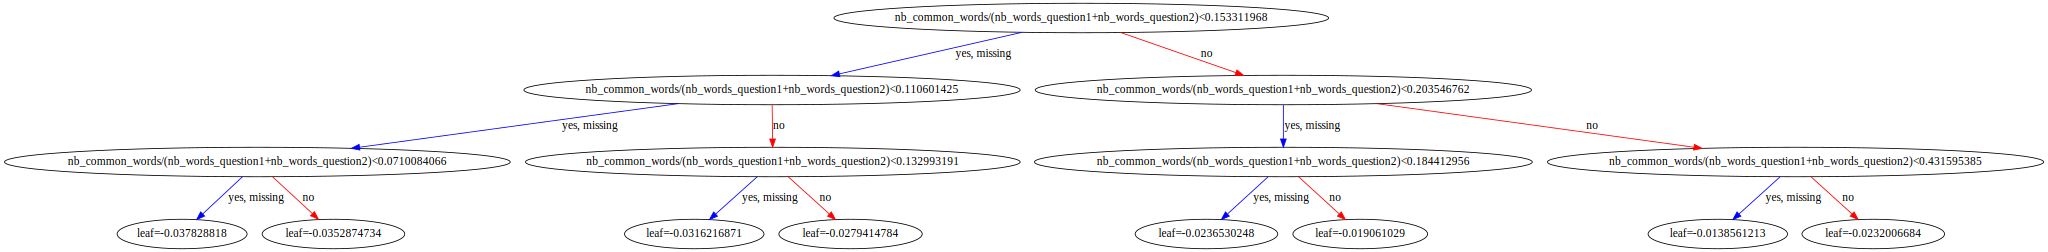

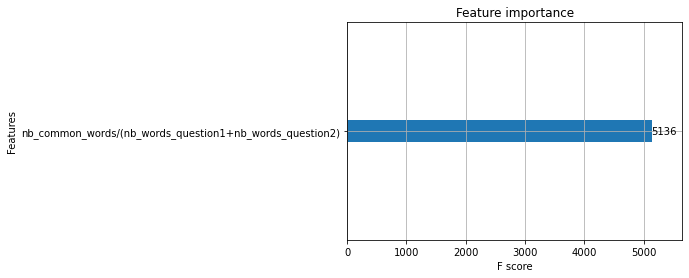

In [69]:
xgboost.plot_importance(model)
xgboost.to_graphviz(model,num_trees=2)